# Data mining

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations

## load the data

In [2]:
train_df = pd.read_csv("../data/train.csv")
print(train_df.shape)
test_df = pd.read_csv("../data/test.csv")
print(test_df.shape)
struc_df = pd.read_csv("../data/structures.csv")
print(struc_df.shape)

(4658147, 6)
(2505542, 5)
(2358657, 6)


In [11]:
train_df.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [12]:
test_df.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [13]:
struc_df.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


## 3d structure of random molecule

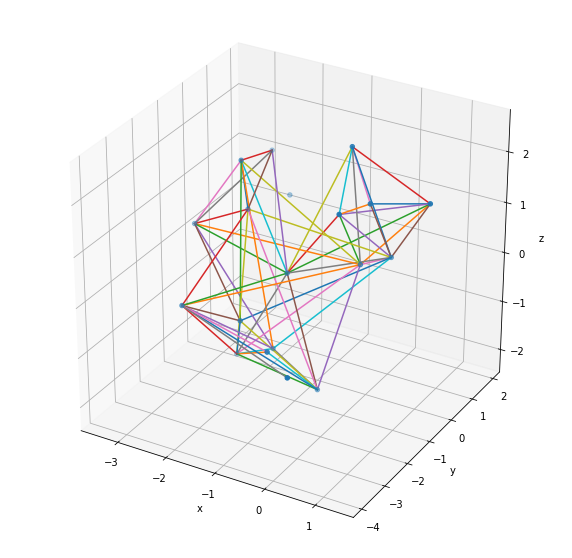

In [168]:
while True:
    s = np.random.randint(low=0,high=130775)
    
    mole_name = 'dsgdb9nsd_' + f"{s:06d}"
    if struc_df["molecule_name"].str.contains(mole_name).sum():
        break
fst_mole = struc_df[struc_df.molecule_name == mole_name]
edges = train_df[train_df.molecule_name == mole_name]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=fst_mole.x, ys=fst_mole.y, zs=fst_mole.z)

def draw_line(row):
    coord = fst_mole[(fst_mole.atom_index == row.atom_index_0) | (fst_mole.atom_index == row.atom_index_1)]
    ax.plot(xs=coord.x, ys=coord.y, zs=coord.z) # ,label=str(row.scalar_coupling_constant))
edges.apply(draw_line,axis=1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

## data exploring

- Number of molecules in each file

From the result bellow, we can see that all the structre information contained in struc_df is corresponding to both the train and test set.

In [8]:
print(train_df.molecule_name.unique().shape)
print(test_df.molecule_name.unique().shape)
print(struc_df.molecule_name.unique().shape)
print(np.intersect1d(train_df.molecule_name.unique(),test_df.molecule_name.unique(),assume_unique=True).shape)
print(np.intersect1d(struc_df.molecule_name.unique(),train_df.molecule_name.unique(),assume_unique=True).shape)

(85003,)
(45772,)
(130775,)
(0,)
(85003,)


- Number of type of atoms

There are 5 kind of atoms in total in this dataset. Even for the least-number atom, F has 2996 instances.

In [18]:
print(struc_df.atom.value_counts().shape)
struc_df.atom.value_counts()


(5,)


H    1208387
C     831726
O     183187
N     132361
F       2996
Name: atom, dtype: int64

- Number of coupling type

The coupling type only shows the relation between element H, C and N and there is no other element between these and the N, F. So I need to consider these "missing values" and there effect to the coupling constant.

In [15]:
print(train_df.type.value_counts().shape)
train_df.type.value_counts()

(8,)


3JHC    1510379
2JHC    1140674
1JHC     709416
3JHH     590611
2JHH     378036
3JHN     166415
2JHN     119253
1JHN      43363
Name: type, dtype: int64

- The distribution of the coupling constant

From the distributionn plot, there are a few distinguishing humps. So there must be a really important parameter in the data. I guess that could be the "type" column

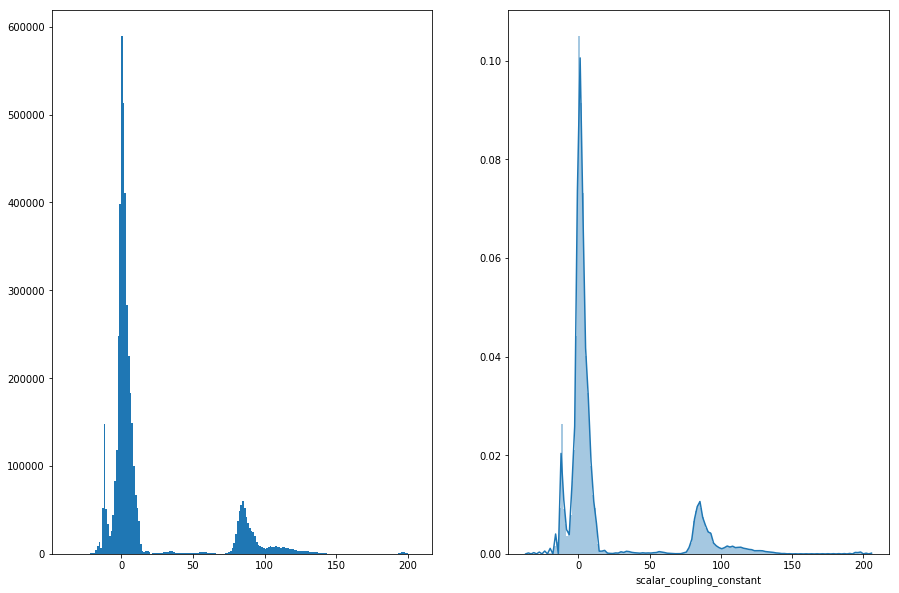

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15,10))
ax[0].hist(train_df.scalar_coupling_constant,bins=200)
sns.distplot(train_df.scalar_coupling_constant,bins=200,ax=ax[1])

- The average coupling constant according to the coupling type

There are a few distinguishing coupling type like "1JHC", "1JHN". They have very different coupling constant. But beyond my guess, the averages of coupling constant are not the centers of the humps in the distribution plot. There are some shifts in between. This could be caused by the other parameters.

In [31]:
avg_const = train_df.groupby('type').scalar_coupling_constant.mean()
avg_const

type
1JHC    94.976153
1JHN    47.479884
2JHC    -0.270624
2JHH   -10.286605
2JHN     3.124754
3JHC     3.688470
3JHH     4.771023
3JHN     0.990730
Name: scalar_coupling_constant, dtype: float64

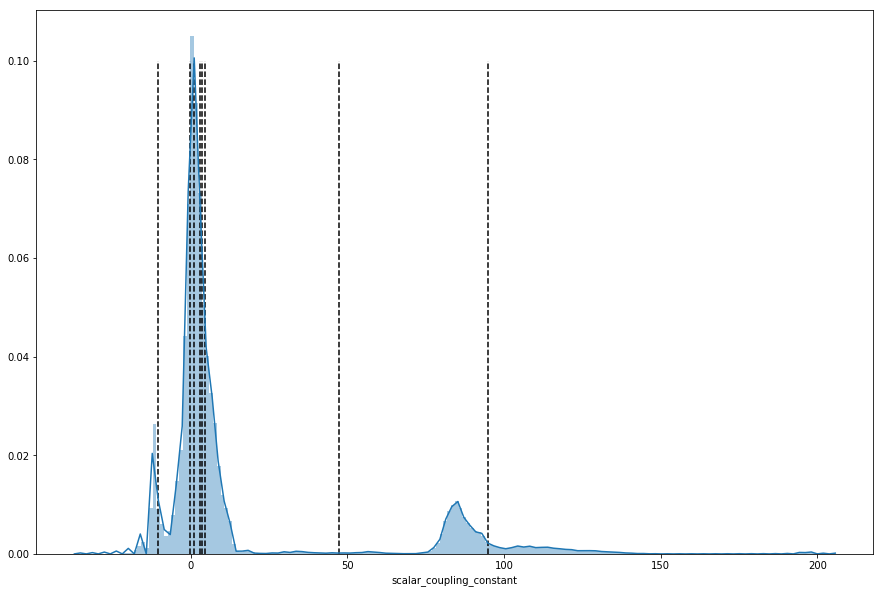

In [45]:
plt.figure(figsize=(15,10))
for i in range(avg_const.shape[0]):
    plt.vlines(x=avg_const[i],ymin=0,ymax=0.1,linestyles='dashed',label=avg_const.index[i])
sns.distplot(train_df.scalar_coupling_constant,bins=200)

- The distribution of number of atoms in each molucule

The distribution of number of atoms looks approximately normal. So these data won't cause much unbalance during the model trainnig.

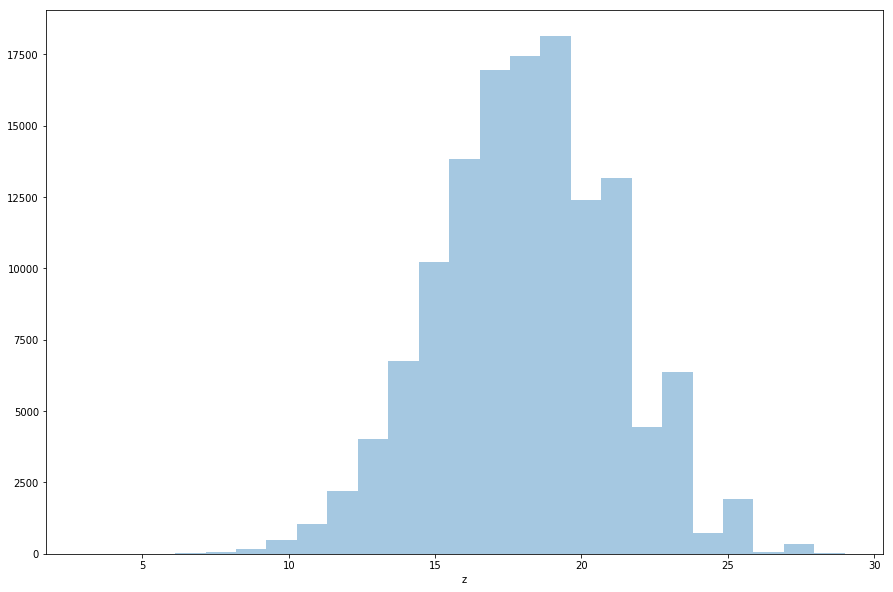

In [50]:
plt.figure(figsize=(15,10))
sns.distplot(struc_df.groupby('molecule_name').count().z,bins=25,kde=False)

## Feature engineering


### 1. Format edges & nodes data

In [24]:
edges_df = pd.concat([train_df[np.delete(train_df.columns.values,-1)],test_df],ignore_index=True)
new_df = pd.DataFrame({'atom_index_0': edges_df[edges_df.atom_index_0 > edges_df.atom_index_1]['atom_index_1'].values,'atom_index_1': edges_df[edges_df.atom_index_0 > edges_df.atom_index_1]['atom_index_0'].values}, index=edges_df[edges_df.atom_index_0 > edges_df.atom_index_1].index.values)
edges_df.update(new_df)
new_df = None

In [15]:
nodes_df = struc_df

In [3]:
edges_df = pd.read_csv("../data/edges.csv")
print(edges_df.shape)
nodes_df = pd.read_csv("../data/nodes.csv")
print(nodes_df.shape)

(20655582, 17)
(2358657, 8)



### 2. Number of atoms in each molecule

The number of atoms in each molecule with definitely affects the whole structure of each molecule and should be stored in the table.

In [3]:
count_df = nodes_df.groupby('molecule_name').count().z
def count_atoms(x):
    return count_df.loc[x.molecule_name]
for i in range(nodes_df.shape[0]):
    nodes_df.set_value(i, "atom_num", count_atoms(nodes_df.iloc[i,:]))
nodes_df["atom_num"] = nodes_df.atom_num.apply(int)
nodes_df.head()

/home/cesare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


,Unnamed: 0,molecule_name,atom_index,atom,x,y,z,atom_num
0,0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,5.0
1,1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,5.0
2,2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,5.0
3,3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,5.0
4,4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,5.0


### 3. Add hidden edges data

In [27]:
# edges_df = edges_df.drop(["Unnamed: 0"],axis=1)
hidden_df = nodes_df.groupby("molecule_name").count().z.reset_index()
hidden_df["z"] = hidden_df.apply(lambda x: combinations(range(x.z),2),axis=1)
hidden_df = pd.DataFrame([(tup.molecule_name,d) for tup in hidden_df.itertuples() for d in tup.z],columns=["molecule_name","atom_index_1"])
hidden_df["atom_index_0"] = hidden_df.atom_index_1.apply(lambda x: x[0])
hidden_df["atom_index_1"] = hidden_df.atom_index_1.apply(lambda x: x[1])
hidden_df = hidden_df[['molecule_name', 'atom_index_0','atom_index_1']]
edges_df = pd.merge(edges_df, hidden_df, how='right', on=['molecule_name', 'atom_index_0','atom_index_1'])
hidden_df = None
edges_df.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,0.0,dsgdb9nsd_000001,0.0,1.0,1JHC
1,1.0,dsgdb9nsd_000001,1.0,2.0,2JHH
2,2.0,dsgdb9nsd_000001,1.0,3.0,2JHH
3,3.0,dsgdb9nsd_000001,1.0,4.0,2JHH
4,4.0,dsgdb9nsd_000001,0.0,2.0,1JHC


### 4. Count the radius of each atom from the origin

The radius of each atom could somehow show the how sparse the molecule structrue is.

In [3]:
def count_radius(row):
    return np.sqrt(row.x**2 + row.y**2 + row.z**2)
nodes_df["radius"] = nodes_df.apply(count_radius,axis=1)
nodes_df.head()

,molecule_name,atom_index,atom,x,y,z,atom_num,radius
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,5,1.085908
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,5,0.006701
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,5,1.779373
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,5,1.776603
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,5,1.778648


### 5. Add known parameters from nodes to edges

In [32]:
edges_df.rename(columns={"atom_index_0":"atom_index"},inplace=True)
edges_df = pd.merge(edges_df,nodes_df,how="left",on=["molecule_name","atom_index"])
edges_df.drop(["atom_num"],axis=1,inplace=True)
edges_df.rename(columns={"atom_index":"atom_index_0","atom":"atom_0","x":"x_0","y":"y_0","z":"z_0","radius":"radius_0"},inplace=True)
edges_df.rename(columns={"atom_index_1":"atom_index"},inplace=True)
edges_df = pd.merge(edges_df,nodes_df,how="left",on=["molecule_name","atom_index"])
edges_df.rename(columns={"atom_index":"atom_index_1","atom":"atom_1","x":"x_1","y":"y_1","z":"z_1","radius":"radius_1"},inplace=True)

### 6. Initialize hidden effect parameters - coupling type

We already add the hiddent edges. But the coulping type between each pair is unkown. So we need to find how each pair related. The wan

In [35]:
edges_df['type'].fillna('XJ'+edges_df['atom_0'] + edges_df["atom_1"],inplace=True)

In [40]:
edges_df[['atom_index_0','atom_index_1']] = edges_df[['atom_index_0','atom_index_1']].astype(int)

In [41]:
edges_df.head()

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,radius_0,atom_1,x_1,y_1,z_1,atom_num,radius_1
0,0.0,dsgdb9nsd_000001,0,1,1JHC,C,-0.012698,1.085804,0.008001,1.085908,H,0.002150,-0.006031,0.001976,5,0.006701
1,1.0,dsgdb9nsd_000001,1,2,2JHH,H,0.002150,-0.006031,0.001976,0.006701,H,1.011731,1.463751,0.000277,5,1.779373
2,2.0,dsgdb9nsd_000001,1,3,2JHH,H,0.002150,-0.006031,0.001976,0.006701,H,-0.540815,1.447527,-0.876644,5,1.776603
3,3.0,dsgdb9nsd_000001,1,4,2JHH,H,0.002150,-0.006031,0.001976,0.006701,H,-0.523814,1.437933,0.906397,5,1.778648
4,4.0,dsgdb9nsd_000001,0,2,1JHC,C,-0.012698,1.085804,0.008001,1.085908,H,1.011731,1.463751,0.000277,5,1.779373


### 7. The distance between different atoms

The distance could influence how strongly different atoms coupled with each other.

In [42]:
dif = edges_df[["x_0","y_0","z_0"]].values - edges_df[["x_1","y_1","z_1"]].values
edges_df['distance'] = np.sqrt(np.sum(np.square(dif), axis=1))
dif = None

### 8. The structure inside atom: number of  neutrons and protons

In [10]:
ele_df = pd.DataFrame([["H",1,0],["C",6,6],["N",7,7],["O",8,8],["F",9,10]],columns=["atom_0","proton_0","neutron_0"])
edges_df = pd.merge(edges_df,ele_df,how="left",on=["atom_0"])
ele_df.columns = ["atom_1","proton_1","neutron_1"]
edges_df = pd.merge(edges_df,ele_df,how="left",on=["atom_1"])

### 9. The  interaction - potential energy

Keesom (permanent–permanent dipoles) interaction in Van der Waals forces
https://en.wikipedia.org/wiki/Intermolecular_force#Keesom_(permanent%E2%80%93permanent_dipoles)_interaction

In [ ]:
edges_df['force'] = 

### 10. Quantify the structure effect using graphframe

In [ ]:
! ./run_build_the_graph.sh

### Save all the work

In [43]:
## the nan id is kept for future removing the unknow effect columns
edges_df.isna().sum()

id               13491893
molecule_name           0
atom_index_0            0
atom_index_1            0
type                    0
atom_0                  0
x_0                     0
y_0                     0
z_0                     0
radius_0                0
atom_1                  0
x_1                     0
y_1                     0
z_1                     0
atom_num                0
radius_1                0
distance                0
dtype: int64

In [11]:
# hidden_df.to_csv("../data/hidden.csv",index=False)
edges_df.to_csv("../data/edges.csv",index=False)
# nodes_df.to_csv("../data/nodes.csv",index=False)
print('Save process done!')

Save process done!


## Splitting data for training the model

In [45]:
print(train_df.shape)
print(test_df.shape)

4658147
2505542


In [59]:
train_df_exp = edges_df.loc[0:(train_df.shape[0]-1),]
train_df_exp["scalar_coupling_constant"] = train_df["scalar_coupling_constant"]
test_df_exp = edges_df.loc[train_df.shape[0]:(train_df.shape[0]+test_df.shape[0]-1),]
train_df_exp.to_csv("../data/train_exp.csv",index=False)
test_df_exp.to_csv("../data/test_exp.csv",index=False)

/home/cesare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
